# Interpretability of Deep Learning: Estimating importance scores
### 1000-719bMSB MIM UW, Neo Christopher Chung

In this lab, we estimate importance scores using backpropagation, which is one of the first XAI methods. There are many names for scores that relate the input features to the output class. Saliency maps, feature attribution or importance scores all refer to the very closely related, if not the same, approach.

In the process, we also learn how to use a pre-trained model, called SqueezeNet (AlexNet-level accuracy with 50x fewer parameters and 0.5MB model size), which can be loaded directly from PyTorch.  
https://arxiv.org/abs/1602.07360
https://en.wikipedia.org/wiki/SqueezeNet

We further look at the ImageNet which is one of the most popular and important database consisted of milliions of images across 20000 categories. For Colab, we use only a small portion of the ImageNet
https://ieeexplore.ieee.org/document/5206848
https://en.wikipedia.org/wiki/ImageNet

Using these ingredients, we calculate backpropgagtion based importance scores from scratch.

Please be mindful of both original (multi-channel) values and summaried 2D values. Both are used and researched in practice.

Adapted from https://github.com/srinadhu/CS231n/blob/master/assignment3/NetworkVisualization-PyTorch.ipynb


In [4]:
import torch
import torchvision
import torchvision.transforms as T
import random
import numpy as np
import pandas as pd
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from matplotlib import cm
# configuration for visualizing with
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

# only if you are running this from google colab an
from google.colab import drive
drive.mount('/content/gdrive')

#sample ImageNet data from https://github.com/CNN-ADF/Task2020
!wget 'https://raw.githubusercontent.com/CNN-ADF/Task2020/master/resources/imagenet_val_25.npz' -q

<ipython-input-4-f480a97f4b63>:7: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


Mounted at /content/gdrive


In [5]:
# helper functions for image processing
def preprocess(img, size=224):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

# load small imagenet data
def load_imagenet_val(num=None):
    f = np.load('imagenet_val_25.npz', allow_pickle=True)
    X = f['X']
    y = f['y']
    class_names = f['label_map'].item()
    idx = np.arange(25)
    np.random.shuffle(idx)
    if num is not None:
        idx = idx[:num]
        X   = X[idx]
        y   = y[idx]
    return X, y, class_names

#X, y, class_names = load_imagenet_val(num=5)

#Load and use all 25 images from a smaller set, downloaded
f = np.load('imagenet_val_25.npz', allow_pickle=True)
X = f['X']
y = f['y']
class_names = f['label_map'].item()
print(X.shape)
print(y.shape)

(25, 224, 224, 3)
(25,)


In [6]:

# check out which number relates to what class names
for y_val in y:
    print(class_names[y_val])

hay
quail
Tibetan mastiff
Border terrier
brown bear, bruin, Ursus arctos
soap dispenser
pajama, pyjama, pj's, jammies
gorilla, Gorilla gorilla
sports car, sport car
toilet tissue, toilet paper, bathroom tissue
stole
lakeside, lakeshore
pirate, pirate ship
bee eater
collie
turnstile
cardoon
Cardigan, Cardigan Welsh corgi
Christmas stocking
space shuttle
daisy
spatula
modem
vase
black swan, Cygnus atratus


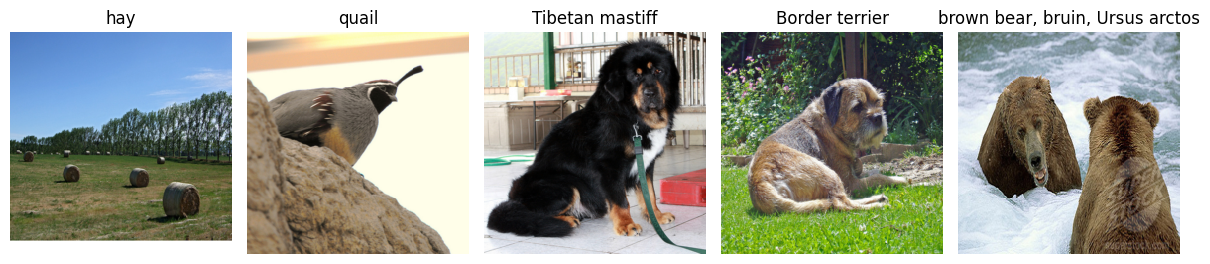

In [8]:
# show some images
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and 0.5MB model size
https://arxiv.org/abs/1602.07360

Recent research on deep neural networks has focused primarily on improving accuracy. For a given accuracy level, it is typically possible to identify multiple DNN architectures that achieve that accuracy level. With equivalent accuracy, smaller DNN architectures offer at least three advantages: (1) Smaller DNNs require less communication across servers during distributed training. (2) Smaller DNNs require less bandwidth to export a new model from the cloud to an autonomous car. (3) Smaller DNNs are more feasible to deploy on FPGAs and other hardware with limited memory. To provide all of these advantages, we propose a small DNN architecture called SqueezeNet. SqueezeNet achieves AlexNet-level accuracy on ImageNet with 50x fewer parameters. Additionally, with model compression techniques we are able to compress SqueezeNet to less than 0.5MB (510x smaller than AlexNet).

https://github.com/forresti/SqueezeNet

In [7]:
# Iandola et al, "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size", arXiv 2016
model = torchvision.models.squeezenet1_1(pretrained=True)
#print(model)

for param in model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 27.1MB/s]


In [9]:
X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
y_tensor = torch.LongTensor(y)
model.eval()
scores = model(X_tensor)
print(scores)
scores_y = scores.gather(1, y_tensor.view(-1, 1)).squeeze()
print(scores_y)

tensor([[ 9.0406,  1.1808,  3.4227,  ...,  4.6864,  8.0145,  5.2129],
        [ 5.9101,  4.6083,  6.9259,  ...,  9.7415,  9.6305,  9.3974],
        [ 1.6097,  4.0396,  4.4560,  ...,  3.4892, 11.6411, 12.5561],
        ...,
        [ 5.5077,  3.8930,  3.3218,  ...,  4.5410,  7.9065, 15.4184],
        [ 7.6427,  8.8772,  4.0593,  ...,  9.6345,  7.5668, 10.8771],
        [ 8.6750, 13.4218, 11.4606,  ...,  6.1399,  5.2605, 10.4970]])
tensor([24.1313, 25.1475, 38.8825, 25.4514, 30.2723, 25.4353, 15.6568, 34.9214,
        22.9094, 13.7762, 18.1419, 10.5448, 23.5066, 46.3714, 39.0091, 27.1299,
        25.8614, 19.7288, 18.6807, 20.9641, 25.2686, 18.7046, 21.7245, 12.6422,
        15.0523])


In [11]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    model.eval()
    X.requires_grad_()

    # 1. Forward pass
    scores = model(X)

    # 2. Get correct class scores
    scores = scores.gather(1, y.view(-1, 1)).squeeze()
    print("== class scores ==")
    print(scores)

    # 3. Backward pass
    scores_size = scores.shape
    ones_tensor = torch.ones(scores_size)
    scores.backward(ones_tensor)

    # 4. retrieve the gradient as saliency map
    saliency = X.grad
    return saliency

def compute_abs(saliency):
    saliency_abs = saliency.abs()
    return saliency_abs

def compute_max(saliency):
    saliency_max, _= torch.max(saliency, dim=1)
    return saliency_max

In [15]:
## calculating gradients for CORRECT labels
# Convert X and y from numpy arrays to Torch Tensors
X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
y_tensor = torch.LongTensor(y)

# Compute saliency maps for images in X
saliency = compute_saliency_maps(X_tensor, y_tensor, model)
print(saliency.shape)

# Convert the saliency map from Torch Tensor to numpy array and show images
# and saliency maps together.
#saliency = saliency.numpy()


== class scores ==
tensor([24.1313, 25.1475, 38.8825, 25.4514, 30.2723, 25.4353, 15.6568, 34.9214,
        22.9094, 13.7762, 18.1419, 10.5448, 23.5066, 46.3714, 39.0091, 27.1299,
        25.8614, 19.7288, 18.6807, 20.9641, 25.2686, 18.7046, 21.7245, 12.6422,
        15.0523], grad_fn=<SqueezeBackward0>)
torch.Size([25, 3, 224, 224])


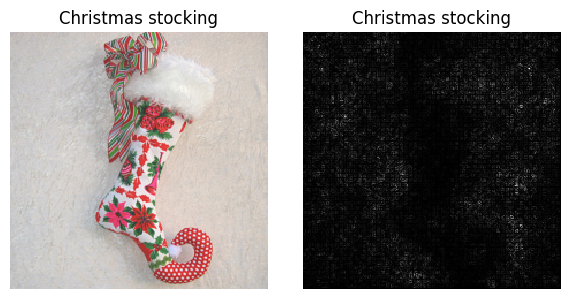

In [16]:
# taking max or max-abs values are typical in the field
saliency_max = compute_max(saliency)
saliency_maxabs = compute_max(compute_abs(saliency))

# show a chosen image and saliency map
i=18

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.imshow(X[i])
plt.title(class_names[y[i]])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(saliency_maxabs[i,:,:])
plt.title(class_names[y[i]])
plt.axis('off')

plt.gcf().tight_layout()


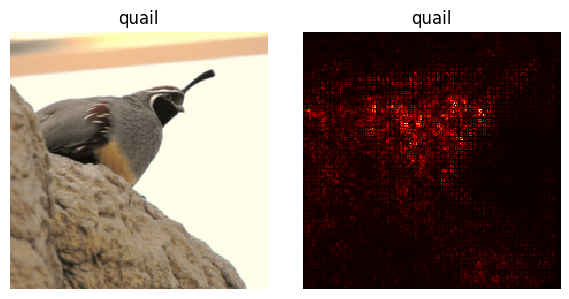

In [17]:
# one could make a different color palette (see cmap)
# https://matplotlib.org/stable/users/explain/colors/colormaps.html

# even more control available
# hue_neg, hue_pos = 0, 359
# cmap = sns.diverging_palette(hue_neg, hue_pos, s=100, center="dark", as_cmap=True)

# show a chosen image and saliency map
i=1

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.imshow(X[i])
plt.title(class_names[y[i]])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(saliency_maxabs[i,:,:], cmap=plt.cm.hot)
plt.title(class_names[y[i]])
plt.axis('off')

plt.gcf().tight_layout()

In [ ]:
# look at the actual values. we call these numbers importance scores
saliency_max[i,:,:].numpy()

array([[-3.8729861e-04,  2.8091606e-03,  4.6291631e-03, ...,
         1.5250454e-03,  2.6028252e-03,  0.0000000e+00],
       [-1.9727729e-03,  1.0636593e-03,  3.6973623e-03, ...,
        -1.2785452e-03,  2.2097339e-03,  0.0000000e+00],
       [-1.0276756e-03, -1.2978617e-03,  1.5352580e-03, ...,
        -9.0014037e-06,  3.9472743e-03,  0.0000000e+00],
       ...,
       [-4.2154700e-03,  6.2057627e-03, -1.3294121e-02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 2.3997980e-03,  1.4775847e-02,  7.2906776e-03, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

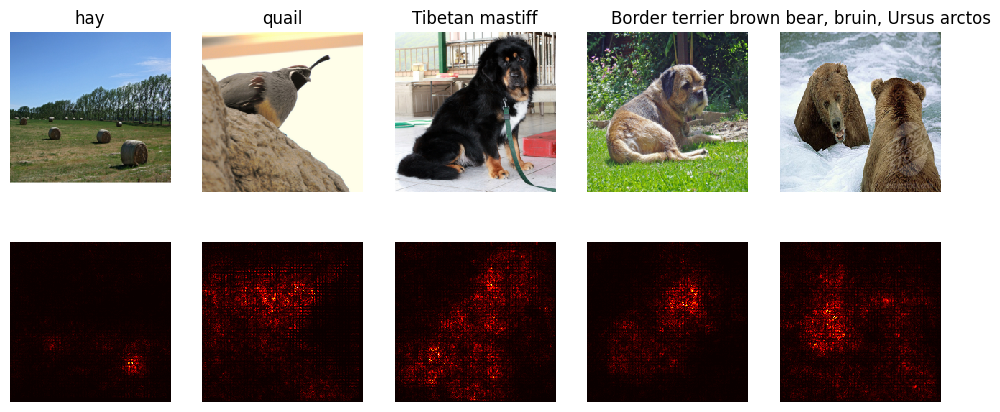

In [18]:
# Plot multiple -- Note that you need to make a figure (5 samples) just like this in the homework, except you use SmoothGrad.
N = 5
for i in range(N):
    plt.subplot(2, N, i + 1)
    plt.imshow(X[i])
    plt.axis('off')
    plt.title(class_names[y[i]])
    plt.subplot(2, N, N + i + 1)
    plt.imshow(saliency_maxabs[i].numpy(), cmap=plt.cm.hot)
    plt.axis('off')
    plt.gcf().set_size_inches(12, 5)
plt.show()

(-0.2, 0.2)

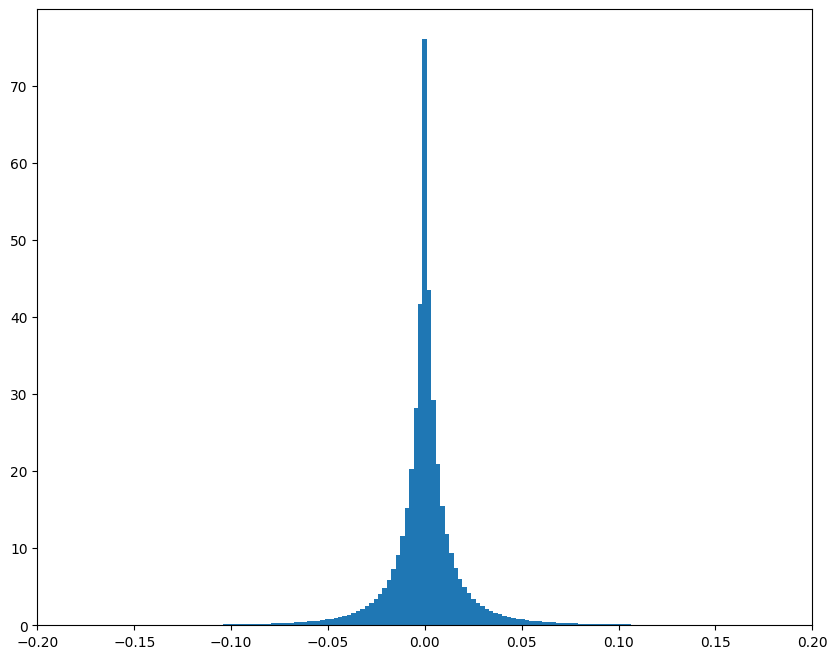

In [19]:
# look at the historgram of the importance scores (raw saliency map values)
plt.hist(saliency.numpy().flatten(), density=True, bins=1000)
plt.xlim([-.2,0.2])

(0.0, 0.25)

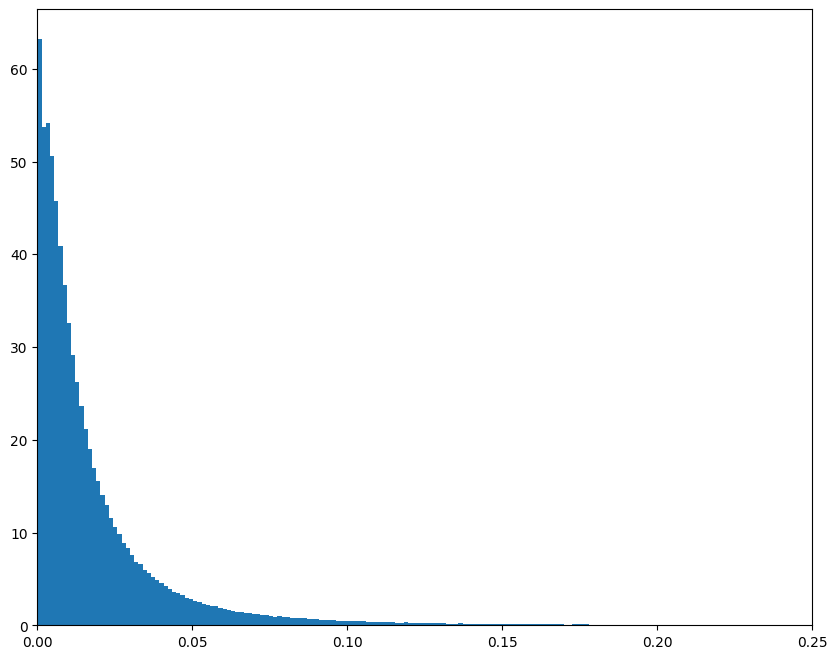

In [20]:
# look at the historgram of max-abs importance scores
plt.hist(saliency_maxabs.numpy().flatten(), density=True, bins=1000)
plt.xlim([0,0.25])

# SmoothGrad

> Smilkov et al. (2017) “SmoothGrad: removing noise by adding noise”.
> The core idea is to take an image of interest, sample similar images by adding noise to the image, then take the average of the resulting sensitivity (saliency) maps for each sampled image.

Let's start building SmoothGrad.

67.3400732314389


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

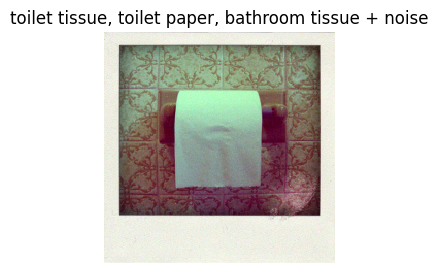

In [21]:
# function to add a noise to an image
def add_noise(x, noise_pct=0.05):
    # Calculate the noise level
    noise_level = noise_pct * np.std(x)
    noise = np.random.normal(0, noise_level, size=x.shape)

    # Add the noise to the sample
    noisy_sample = x + noise

    # Clip the values to ensure they remain within the valid range (0-255 for uint8 images)
    noisy_sample = np.clip(noisy_sample, 0, 255).astype(np.uint8)

    return noisy_sample

# Example
i = 9
sample = X[i]
print(np.std(sample))

noisy_sample = add_noise(x=sample, noise_pct=0.05)

# Visualize the noise-added sample
plt.figure(figsize=(3, 3))
plt.imshow(noisy_sample)
plt.title(class_names[y[i]] + " + noise")
plt.axis('off')


In [22]:
y_tensor

tensor([958,  85, 244, 182, 294, 804, 697, 366, 817, 999, 824, 975, 724,  92,
        231, 877, 946, 264, 496, 812, 985, 813, 662, 883, 100])

== class scores ==
tensor(13.1470, grad_fn=<SqueezeBackward0>)


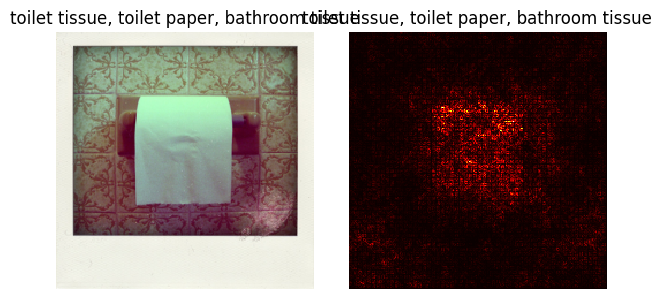

In [23]:
# Compute saliency map from a noisy image

# numpy array must be converted to a PyTorch tensor and processed using the same preprocess function
noisy_sample_tensor = torch.tensor(noisy_sample, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
noisy_sample_tensor = preprocess(Image.fromarray(noisy_sample))

saliency = compute_saliency_maps(noisy_sample_tensor, y_tensor[i].unsqueeze(0), model)
saliency_max = compute_max(saliency)
saliency_maxabs = compute_max(compute_abs(saliency))

plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.imshow(X[i])
plt.title(class_names[y[i]])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(saliency_maxabs[0,:,:].detach().numpy(), cmap=plt.cm.hot)
plt.title(class_names[y[i]])
plt.axis('off')

plt.gcf().tight_layout()


# Homework

Make a function to create SmoothGrad, where the input arguments are X, y, model, n, and noise_pct. For simplicity, we only consider max-abs values. The below is the step for the SmoothGrad function in details:

1. Ues add_noise to add noise (controlled by noise_pct) to a sample
2. The noisy sample is processed through compute_saliency_maps, where saliency_maxabs is saved. This process is repeat *n* times.
3. Take and return the avergeof *n* saliency_maxabs arrays.

Visualize the first five images and their SmoothGrad heatmaps. See and compare that with the figure above using (vanilla) salincy maps.

Please submit the notebook and the PDF/PNG image of these five images and their SmoothGrad heatmaps.

In [ ]:
def create_smoothgrad(X, y, model, n, noise_pct):
  saliency_maps = []
  k = X.shape[0]
  for i in range(k):
    single_maps = []
    for j in range(n):

      noisy_X = add_noise(x=X[i], noise_pct=noise_pct)
      noisy_sample_tensor = preprocess(Image.fromarray(noisy_X))
      saliency = compute_saliency_maps(noisy_sample_tensor, y_tensor[i].unsqueeze(0), model)
      saliency_maxabs = compute_max(compute_abs(saliency))
      single_maps.append(saliency_maxabs[0].detach())

    single_maps_tensor = torch.stack(single_maps)
    smoothgrad = torch.mean(single_maps_tensor, dim=0)
    saliency_maps.append(smoothgrad)

  return torch.stack(saliency_maps)

n = 50
k = 5
noise_pct = 0.1

saliency_maps = create_smoothgrad(X[:k], y[:k], model, n, noise_pct)

== class scores ==
tensor([24.1313, 25.1475, 38.8825, 25.4514, 30.2723, 25.4353, 15.6568, 34.9214,
        22.9094, 13.7762, 18.1419, 10.5448, 23.5066, 46.3714, 39.0091, 27.1299,
        25.8614, 19.7288, 18.6807, 20.9641, 25.2686, 18.7046, 21.7245, 12.6422,
        15.0523], grad_fn=<SqueezeBackward0>)


<Figure size 1200x500 with 0 Axes>

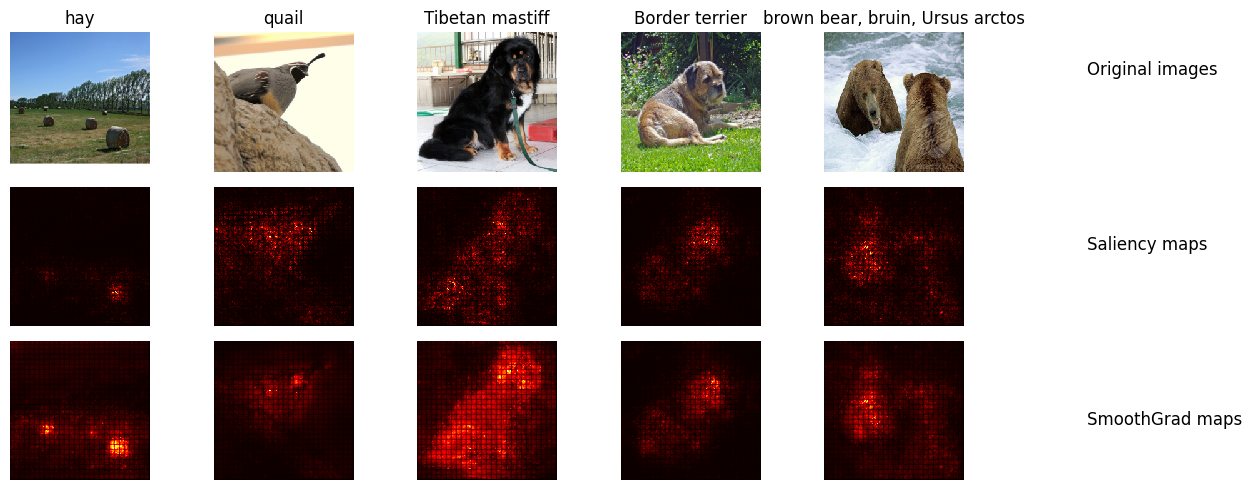

<Figure size 1000x800 with 0 Axes>

In [50]:
# we did this before

X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
y_tensor = torch.LongTensor(y)
saliency = compute_saliency_maps(X_tensor, y_tensor, model)
saliency_maxabs = compute_max(compute_abs(saliency))

plt.figure(figsize=(12, 5))

fig, axes = plt.subplots(3, k, figsize=(12, 5))

for i in range(k):
    axes[0, i].imshow(X[i])
    axes[0, i].axis('off')
    axes[0, i].set_title(class_names[y[i]])

    axes[1, i].imshow(saliency_maxabs[i].cpu().numpy(), cmap=plt.cm.hot)
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel("Saliency", fontsize=12)

    axes[2, i].imshow(saliency_maps[i].cpu().numpy(), cmap=plt.cm.hot)
    axes[2, i].axis('off')
    if i == 0:
        axes[2, i].set_ylabel("SmoothGrad", fontsize=12)

fig.text(0.95, 0.85, 'Original images', fontsize=12, va='center')
fig.text(0.95, 0.5, 'Saliency maps', fontsize=12, va='center')
fig.text(0.95, 0.15, 'SmoothGrad maps', fontsize=12, va='center')

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()
plt.savefig('stanowski_smoothgrad.png', dpi=300, bbox_inches='tight')